# User agent analysis

## Load data from Gaffer

In [1]:
import requests
import json
import sys
import gaffer
import threatgraph
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
g = threatgraph.Gaffer()
g.use_cert()

In [3]:
op = gaffer.OperationChain([
    gaffer.GetAllElements(entities=[
        gaffer.ViewGroup("device", exclude=["count", "time"])
    ], edges=None),
    gaffer.GetWalks(
        operations=[
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("hasip", exclude=["count", "time"])
                ], entities=None, include="OUTGOING")
            ]), 
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("useragent")
                ], entities=None, include="OUTGOING")
            ])
        ],
        limit=10000000)
])

query = op.encode()
res = g.execute_chunked(op)

useragents = {}
timestamps = {}
counts = {}

all_useragents = set()
all_devices = set()

for v in res:

    try:
        ent = json.loads(v)

    except Exception:
        continue

    dev = list(ent["entities"][0].keys())[0]
    ua = list(ent["entities"][2].keys())[0]
    
    # Truncate user-agent string
    ua = ua[:30]
    k = (dev, ua)

    if not k in counts:
        counts[k] = 0
        timestamps[k] = set()
        
    if not dev in useragents:
        useragents[dev] = set()

    ts = ent["edges"][1][0]["properties"]["time"]["uk.gov.gchq.gaffer.time.RBMBackedTimestampSet"]["timestamps"]
    cnt = ent["edges"][1][0]["properties"]["count"]

    counts[k] += cnt
    timestamps[k].update(ts)
    useragents[dev].add(ua)
    all_useragents.add(ua)
    all_devices.add(dev)

In [4]:
all_devices = list(all_devices)
all_useragents = list(all_useragents)

## Construct heatmap matrix

In [5]:
def get_counts(ua, dev):
    if ua in useragents[dev]: return counts[(dev, ua)]
    return 0

datas = [ [ get_counts(ua, dev) for dev in all_devices ] for ua in all_useragents]
df = pd.DataFrame(datas, index=all_useragents, columns=all_devices)
df["score"] = df.sum(axis=1)

In [6]:
df

,traverses-mac,tirasse-mac,dramatic-mac,calcannea-cb,languid-mac,calcannea-mac,dgmac,daniel-chromebook,terrestrial-mac,serotinal-mac,...,elysium-mac,minesweepers-mac,abroad-android,essential-chrome,MalcomWare-PC,ludicrous-mac,turing-macbook,turing-minimacbook,misskitty-mac,score
Microsoft BITS/7.8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,217
ACC_2.00.3024_17F33DFE9BCBC137,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
CaptiveNetworkSupport-346.50.1,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,2
com.apple.trustd/1.0,0,0,7,0,5,0,0,0,12,0,...,10,0,0,0,0,0,0,1,0,43
Windows-Update-Agent/10.0.1001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,212
mobileassetd (unknown version),1,0,2,0,0,0,0,0,1,0,...,1,2,0,0,0,0,0,1,0,13
RunFreshclam/2.18.1 (Macintosh,0,0,0,0,0,0,0,0,0,0,...,0,30,0,0,0,0,0,0,53,83
Mac OS X/10.13.4 (17E199),0,0,41,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,64
ACC_2.00.3024_1D121C0259B2E9EB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
Mozilla/5.0 (X11; Linux x86_64,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [7]:
my_fn = lambda x: np.log(x + 0.001)

In [8]:
df2 = df.copy()
df2[all_devices] = df2[all_devices].apply(my_fn)
df2 = df2.sort_values(by="score", ascending=False)
df2

,traverses-mac,tirasse-mac,dramatic-mac,calcannea-cb,languid-mac,calcannea-mac,dgmac,daniel-chromebook,terrestrial-mac,serotinal-mac,...,elysium-mac,minesweepers-mac,abroad-android,essential-chrome,MalcomWare-PC,ludicrous-mac,turing-macbook,turing-minimacbook,misskitty-mac,score
Mozilla/5.0 (Macintosh; Intel,1.946053,6.448891,10.027253,-6.907755,7.843064,0.001000,0.693647,-6.907755,8.993552,8.225503,...,7.626083,7.820440,-6.907755,-6.907755,-6.907755,2.565026,-6.907755,5.231114,8.932345,85835
Roblox/Darwin,-6.907755,-6.907755,10.867349,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,...,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,52436
Mozilla/5.0 (X11; CrOS x86_64,-6.907755,-6.907755,-6.907755,9.608244,-6.907755,-6.907755,-6.907755,4.043069,-6.907755,-6.907755,...,-6.907755,-6.907755,-6.907755,5.236447,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,24066
Microsoft-Delivery-Optimizatio,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,...,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,10940
Mozilla/5.0 EA Download Manage,-6.907755,-6.907755,9.024613,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,...,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,8305
ProtoHttp 1.3/DS 15.1.2.3.0 (A,-6.907755,-6.907755,8.704005,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,...,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,6027
python-requests/2.13.0,-6.907755,-6.907755,8.471568,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,...,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,4777
Mozilla/5.0 (X11; Ubuntu; Linu,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,...,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,4351
trustd (unknown version) CFNet,3.465767,2.833272,6.282269,-6.907755,5.774555,-6.907755,1.098946,-6.907755,6.495267,5.837733,...,5.953246,5.087603,-6.907755,-6.907755,-6.907755,0.693647,1.098946,3.465767,5.411651,3743
Mozilla/5.0 (Linux; Android 6.,-6.907755,-6.907755,-6.907755,6.018596,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,...,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,3727


## Plot heatmap

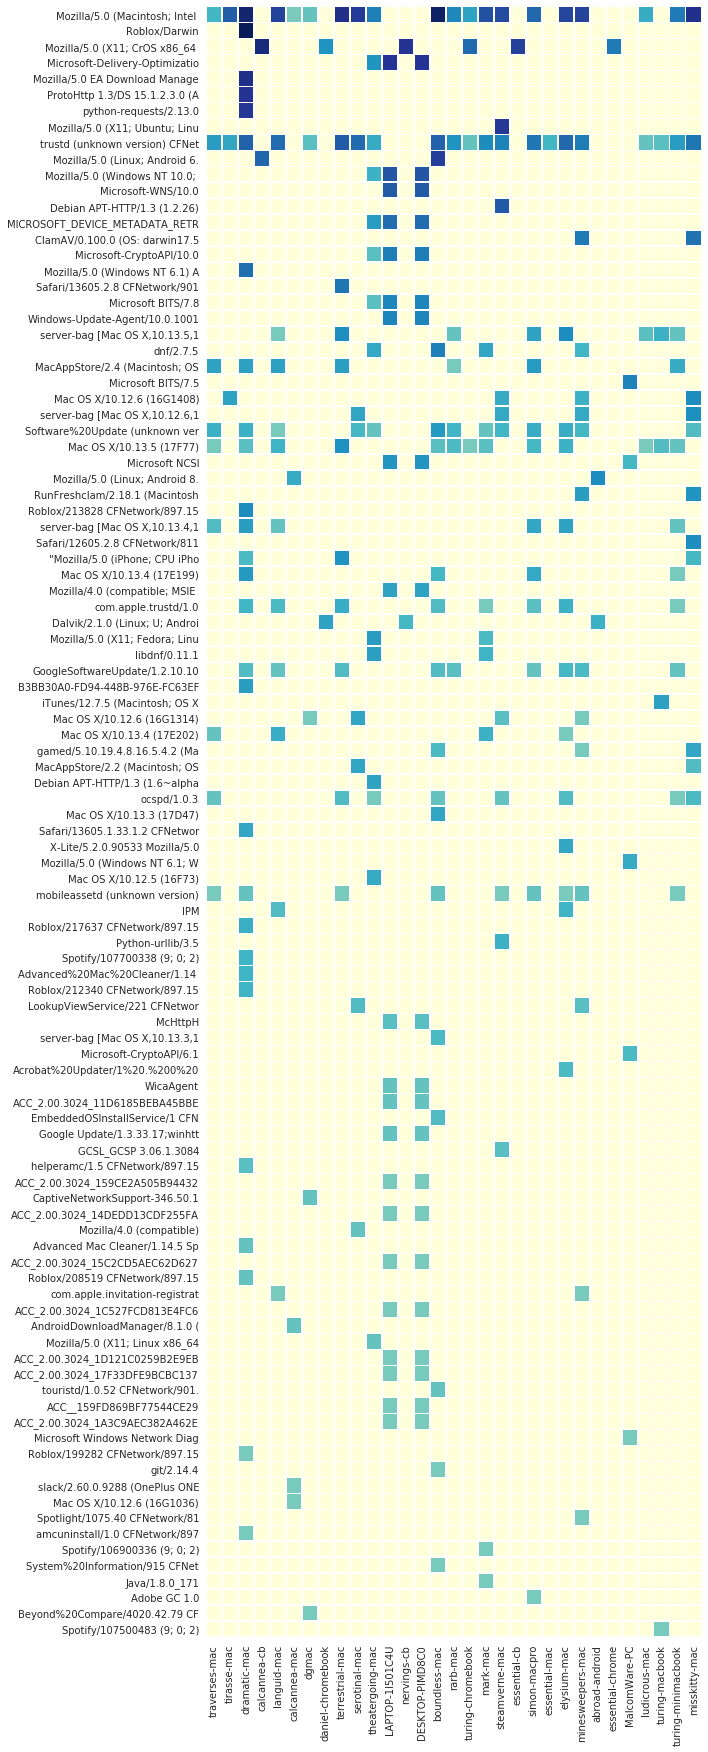

In [9]:
sns.set(style="white")
plt.figure(figsize=(20, 30))
sns.heatmap(df2[all_devices], square=True, linewidths=0.5, cbar=False, cmap="YlGnBu")
plt.show()

## User agents only in use on one device

In [10]:
df3 = df.copy()
df3 = df3.apply(lambda x: [1 if v > 0 else 0 for v in x])
df3["count"] = df3[all_devices].apply(np.count_nonzero, axis=1)
df3

,traverses-mac,tirasse-mac,dramatic-mac,calcannea-cb,languid-mac,calcannea-mac,dgmac,daniel-chromebook,terrestrial-mac,serotinal-mac,...,minesweepers-mac,abroad-android,essential-chrome,MalcomWare-PC,ludicrous-mac,turing-macbook,turing-minimacbook,misskitty-mac,score,count
Microsoft BITS/7.8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3
ACC_2.00.3024_17F33DFE9BCBC137,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
CaptiveNetworkSupport-346.50.1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,1
com.apple.trustd/1.0,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,8
Windows-Update-Agent/10.0.1001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
mobileassetd (unknown version),1,0,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,1,9
RunFreshclam/2.18.1 (Macintosh,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,2
Mac OS X/10.13.4 (17E199),0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,4
ACC_2.00.3024_1D121C0259B2E9EB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
Mozilla/5.0 (X11; Linux x86_64,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


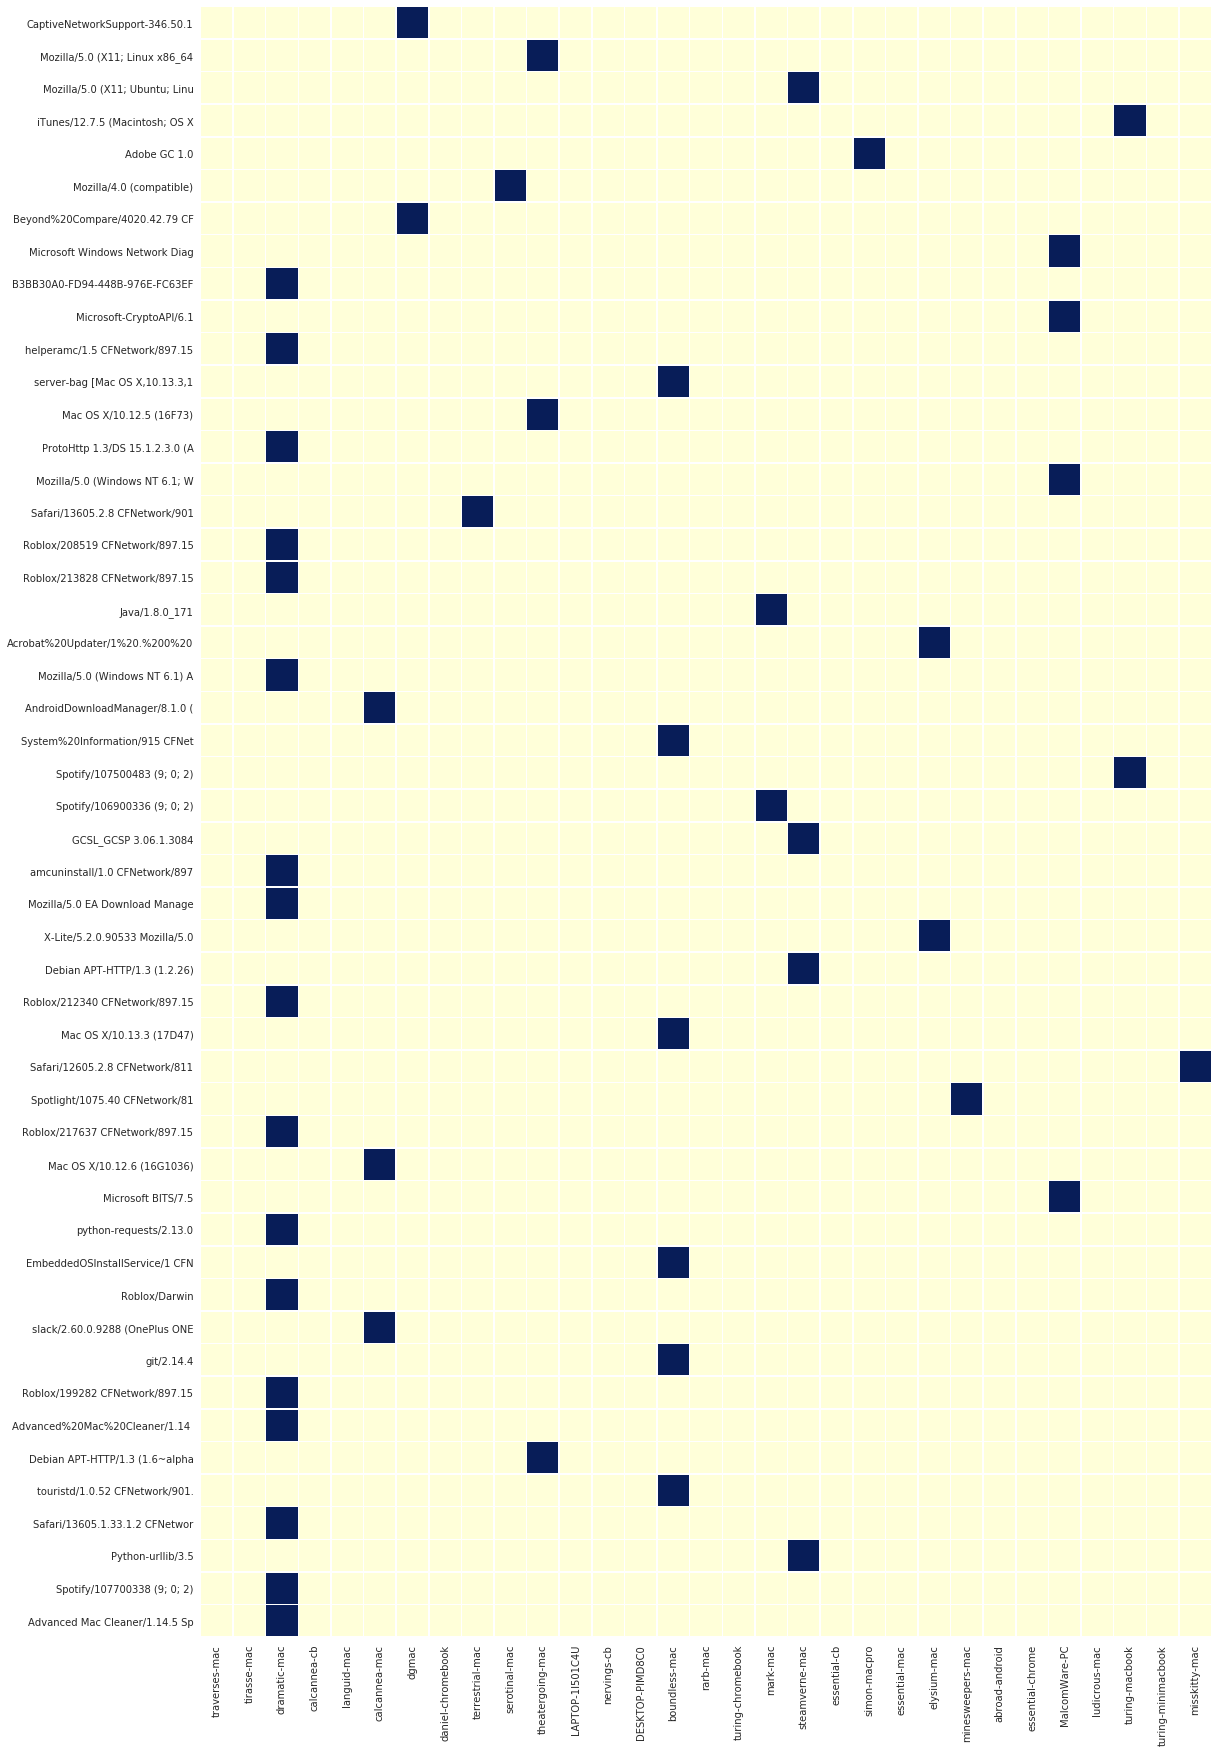

In [11]:
plt.figure(figsize=(20, 30))
sns.heatmap(df3[df3["count"] < 2][all_devices], square=True, linewidths=0.5, cbar=False, cmap="YlGnBu")
plt.show()

## Which devices have the highest number of unique user agents?

In [12]:
df3[df3["count"] < 2][all_devices].sum().to_frame("count").sort_values("count", ascending=False)

,count
dramatic-mac,17
boundless-mac,6
MalcomWare-PC,4
steamverne-mac,4
theatergoing-mac,3
calcannea-mac,3
turing-macbook,2
dgmac,2
mark-mac,2
elysium-mac,2
